<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Load data
data_url = 'https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv'
data = pd.read_csv(data_url, parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [29]:
# Calculate speed and distances
epsilon = 1e-5
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [30]:
data


,Index,Tag,Latitude,Longitude,Time.Stamp,Time_diff,Lat_diff,Lon_diff,Speed
545,1067,5739,-13.097825,33.149230,2022-06-25 18:10:00,0.0,0.000000,0.000000e+00,0.000000e+00
575,1071,5739,-13.097773,33.149242,2022-06-25 18:45:00,2100.0,0.000052,1.200000e-05,2.541269e-08
594,1073,5739,-13.098073,33.145677,2022-06-25 19:15:00,1800.0,-0.000300,-3.565000e-03,1.987556e-06
629,1077,5739,-13.098188,33.145678,2022-06-25 19:45:00,1800.0,-0.000115,1.000000e-06,6.389130e-08
648,1079,5739,-13.105288,33.148128,2022-06-25 20:15:00,1800.0,-0.007100,2.450000e-03,4.172681e-06
...,...,...,...,...,...,...,...,...,...
378625,61230,5782,-13.210522,33.077262,2023-10-31 19:00:00,3600.0,0.000113,2.095000e-03,5.827904e-07
378656,61259,5782,-13.210608,33.080610,2023-10-31 20:00:00,3600.0,-0.000086,3.348000e-03,9.303068e-07
378687,61287,5782,-13.215273,33.076125,2023-10-31 21:01:00,3660.0,-0.004665,-4.485000e-03,1.768109e-06
378719,61315,5782,-13.210075,33.069102,2023-10-31 22:01:00,3600.0,0.005198,-7.023000e-03,2.427049e-06


In [31]:
# Categorize movements
def categorize_movement(df):
    conditions = [
        (df['Lat_diff'] == 0) & (df['Lon_diff'] == 0),
        (df['Lat_diff'] > 0),
        (df['Lat_diff'] < 0),
        (df['Lon_diff'] > 0),
        (df['Lon_diff'] < 0)
    ]
    choices = ['stationary', 'north', 'south', 'east', 'west']
    df['Movement'] = np.select(conditions, choices, default='stationary')
    return df

In [32]:
data = categorize_movement(data)

In [37]:
# Encode Movement Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Movement_Label'] = label_encoder.fit_transform(data['Movement'])


In [38]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']])


In [39]:
# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data.iloc[i+sequence_length]['Movement_Label']
        sequences.append(seq[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']].values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 10
X, y = create_sequences(data, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)


In [41]:
# Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)

In [42]:
# Initialize model, loss, and optimizer
model = LSTMClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [43]:
# Training and Validation Function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_accuracy = correct / total

        # Evaluation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_accuracy = val_correct / val_total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss / len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}')

# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Train Loss: 1.3427, Train Accuracy: 0.5051, Val Loss: 1.3451, Val Accuracy: 0.5006
Epoch 2/10, Train Loss: 1.3598, Train Accuracy: 0.5387, Val Loss: 1.4088, Val Accuracy: 0.4956
Epoch 3/10, Train Loss: 1.4081, Train Accuracy: 0.4967, Val Loss: 1.4096, Val Accuracy: 0.4956
Epoch 4/10, Train Loss: 1.3747, Train Accuracy: 0.5132, Val Loss: 1.3258, Val Accuracy: 0.5635
Epoch 5/10, Train Loss: 1.2798, Train Accuracy: 0.6103, Val Loss: 1.2419, Val Accuracy: 0.6457
Epoch 6/10, Train Loss: 1.2563, Train Accuracy: 0.6369, Val Loss: 1.2851, Val Accuracy: 0.6055
Epoch 7/10, Train Loss: 1.2497, Train Accuracy: 0.6434, Val Loss: 1.2717, Val Accuracy: 0.6158
Epoch 8/10, Train Loss: 1.2475, Train Accuracy: 0.6467, Val Loss: 1.2243, Val Accuracy: 0.6708
Epoch 9/10, Train Loss: 1.2457, Train Accuracy: 0.6478, Val Loss: 1.2292, Val Accuracy: 0.6626
Epoch 10/10, Train Loss: 1.2455, Train Accuracy: 0.6480, Val Loss: 1.2492, Val Accuracy: 0.6379


Classification Report:
              precision    recall  f1-score   support

        east       0.00      0.00      0.00        60
       north       0.78      0.39      0.52     37964
       south       0.59      0.89      0.71     38268
  stationary       0.00      0.00      0.00       255
        west       0.00      0.00      0.00        63

    accuracy                           0.64     76610
   macro avg       0.27      0.26      0.25     76610
weighted avg       0.68      0.64      0.61     76610

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


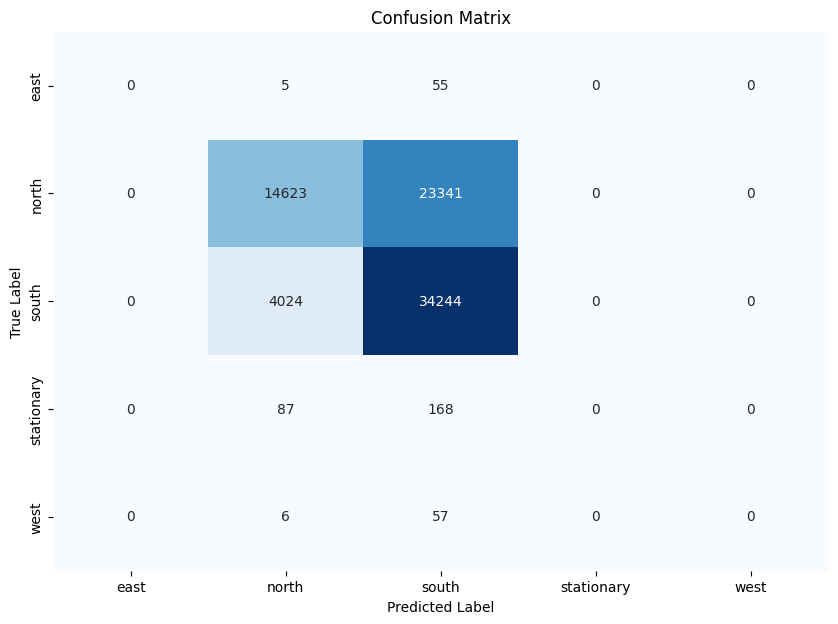

In [44]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)


In [46]:
# Initialize model, loss, and optimizer
model = LSTMClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [47]:
# Training and Validation Function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_accuracy = correct / total

        # Evaluation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_accuracy = val_correct / val_total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss / len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}')

# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Train Loss: 1.3424, Train Accuracy: 0.5054, Val Loss: 1.3447, Val Accuracy: 0.5051
Epoch 2/10, Train Loss: 1.2627, Train Accuracy: 0.6297, Val Loss: 1.2358, Val Accuracy: 0.6659
Epoch 3/10, Train Loss: 1.2489, Train Accuracy: 0.6454, Val Loss: 1.2337, Val Accuracy: 0.6611
Epoch 4/10, Train Loss: 1.2462, Train Accuracy: 0.6479, Val Loss: 1.2458, Val Accuracy: 0.6434
Epoch 5/10, Train Loss: 1.2413, Train Accuracy: 0.6528, Val Loss: 1.2211, Val Accuracy: 0.6777
Epoch 6/10, Train Loss: 1.2384, Train Accuracy: 0.6568, Val Loss: 1.2223, Val Accuracy: 0.6757
Epoch 7/10, Train Loss: 1.2341, Train Accuracy: 0.6610, Val Loss: 1.2386, Val Accuracy: 0.6551
Epoch 8/10, Train Loss: 1.2289, Train Accuracy: 0.6664, Val Loss: 1.2400, Val Accuracy: 0.6534
Epoch 9/10, Train Loss: 1.2276, Train Accuracy: 0.6685, Val Loss: 1.2189, Val Accuracy: 0.6787
Epoch 10/10, Train Loss: 1.2261, Train Accuracy: 0.6697, Val Loss: 1.2396, Val Accuracy: 0.6534


In [ ]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch.nn as nn

class SimpleRNNClassifier(nn.Module):
    def __init__(self):
        super(SimpleRNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size=5, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 5)  # Assuming 5 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return self.softmax(out)


In [ ]:
# Training and Validation Function
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_accuracy = correct / total

        # Evaluation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_accuracy = val_correct / val_total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss / len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}')

# Run training and evaluation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# Post-training analysis
all_y_pred, all_y_true = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_y_pred.extend(predicted.numpy())
        all_y_true.extend(y_batch.numpy())

print("Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()